# VCLOD Test for Coefficient 4

This script performs the main VCLOD test for this thesis with a specific diffusion coefficient. We investigate the energy error of the VCLOD dependent on the updated correctors. For this purpose, we update every corrector individually and compare it to the reference solution. This enables a good comparison between percentages. We desire to yield a fast decrease of the energy error of the VCLOD method since, due to the error indicator, we sort and update the element correctors in terms of the effect that comes with the perturbation.    

In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sparse
import random
import csv

%matplotlib notebook
import matplotlib.pyplot as plt
from visualize import drawCoefficient
from data import * 

from gridlod import interp, coef, util, fem, world, linalg, femsolver
import pg_rand, femsolverCoarse, buildcoef2d
from gridlod.world import World

## Result function

The 'result' function investigates the VCLOD for each percentage. The reference solution is computed by a standard FEM on the fine mesh. We compute the 'worst solution' that represents zero percentage updating and clearly has no computational cost at all. Afterwards, we compute the error indicator for the given patch size $k=4$ and use every value gradually. Furthermore we store the resulting energy error for the VCLOD as well as the optimal energy error that results from 100 percentage updating. Once again, we take advantage of the 'gridlod' module in order to compute the required matrices.   

In [2]:
def result(pglod, world, A, R, f, k, String):
    print "-------------- " + String + " ---------------" 
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement
    
    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)
        
    # new Coefficient
    ANew = R.flatten()
    Anew = coef.coefficientFine(NWorldCoarse, NCoarseElement, ANew)
    
    # reference solution
    f_fine = np.ones(NpFine)
    uFineFem, AFine, MFine = femsolver.solveFine(world, ANew, f_fine, None, boundaryConditions)
    
    # worst solution
    KFull = pglod.assembleMsStiffnessMatrix()
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)                                 
    
    bFull = MFull*f
    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)
    
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    
    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors
    
    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uCoarse = xFull
    uLodFine = modifiedBasis*xFull
    
    uLodFineWorst = uLodFine
    
    # energy error
    errorworst = np.sqrt(np.dot(uFineFem - uLodFineWorst, AFine*(uFineFem - uLodFineWorst)))
    
    # tolerance = 0 
    vis, eps = pglod.updateCorrectors(Anew, 0, f, 1, clearFineQuantities=False, Computing=False)
    
    PotentialCorrectors = np.sum(vis)
    elemente = np.arange(np.prod(NWorldCoarse))
            
    # identify tolerances
    epsnozero = filter(lambda x: x!=0, eps)
    
    assert(np.size(epsnozero) != 0)
    
    mini = np.min(epsnozero)
    minilog = int(round(np.log10(mini)-0.49))
    epsnozero.append(10**(minilog))
    ToleranceListcomplete = []
    for i in range(0,int(np.size(epsnozero))):
        ToleranceListcomplete.append(epsnozero[i])

    ToleranceListcomplete.sort()
    ToleranceListcomplete = np.unique(ToleranceListcomplete)

    # with tolerance
    errorplotinfo = []
    tolerancesafe = []
    errorBest = []
    errorWorst = []
    recomputefractionsafe = []
    recomputefraction = 0
    Correctors = 0
    leng = np.size(ToleranceListcomplete)
    for k in range(leng-1,-1,-1):
        tol = ToleranceListcomplete[k]
        print " --- "+ str(-k+leng) + "/" + str(leng)+ " --- Tolerance: " + str(round(tol,5)) + " in "+ String +" ---- ", 
        vistol = pglod.updateCorrectors(Anew, tol, f, clearFineQuantities=False, Testing=True)
        
        Correctors += np.sum(vistol)
        
        recomputefraction += float(np.sum(vistol))/PotentialCorrectors * 100
        recomputefractionsafe.append(recomputefraction)
        
        KFull = pglod.assembleMsStiffnessMatrix()
        MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
        free  = util.interiorpIndexMap(NWorldCoarse)                                 

        bFull = MFull*f
        KFree = KFull[free][:,free]
        bFree = bFull[free]

        xFree = sparse.linalg.spsolve(KFree, bFree)
        basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)

        basisCorrectors = pglod.assembleBasisCorrectors()

        modifiedBasis = basis - basisCorrectors

        xFull = np.zeros(NpCoarse)
        xFull[free] = xFree
        uCoarse = xFull
        uLodFine = modifiedBasis*xFull
        
        #energy error
        errortol = np.sqrt(np.dot(uFineFem - uLodFine, AFine*(uFineFem - uLodFine)))
        
        errorplotinfo.append(errortol)
        tolerancesafe.append(tol)
    
    # 100% updating
    uLodFinebest = uLodFine
    errorbest = np.sqrt(np.dot(uFineFem - uLodFinebest, AFine*(uFineFem - uLodFinebest)))
    
    for k in range(leng-1,-1,-1):
        errorBest.append(errorbest)
        errorWorst.append(errorworst)

    return vis, eps, PotentialCorrectors, recomputefractionsafe, errorplotinfo, errorWorst, errorBest

## Preparations

We use the same setting as we have already used before containing the 'buildcoef2d' class in order to construct the coefficient. We visualize the coefficient and store the information in an extern folder.

<IPython.core.display.Javascript object>


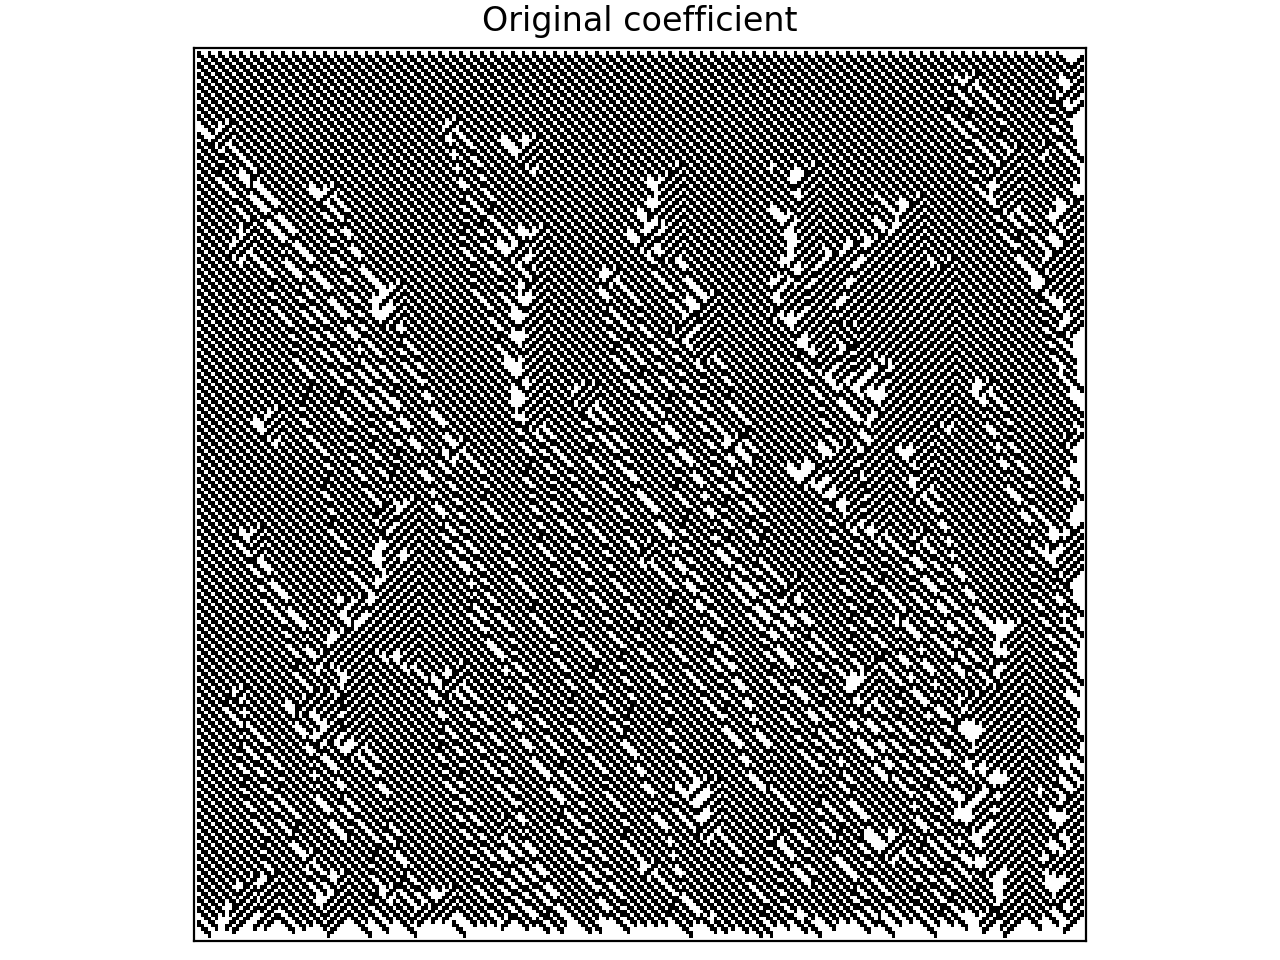

In [4]:
bg = 0.05       #background
val = 1         #values

#fine World
NWorldFine = np.array([256, 256])
NpFine = np.prod(NWorldFine+1)                                                                               

#coarse World
NWorldCoarse = np.array([16,16])
NpCoarse = np.prod(NWorldCoarse+1)

#ratio between Fine and Coarse
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

#righthandside
f = np.ones(NpCoarse)

#Coefficient 4
CoefClass = buildcoef2d.Coefficient2d(NWorldFine, 
                        bg                  = bg, 
                        val                 = val, 
                        thick               = 1, 
                        space               = 0, 
                        probfactor          = 1, 
                        right               = 0, 
                        down                = 0, 
                        diagr1              = 1, 
                        diagr2              = 0, 
                        diagl1              = 1, 
                        diagl2              = 0, 
                        LenSwitch           = [4,5,6,7,8], 
                        thickSwitch         = None, 
                        equidistant         = None, 
                        ChannelHorizontal   = None, 
                        ChannelVertical     = None,
                        BoundarySpace       = None) 

A = CoefClass.BuildCoefficient()
ABase = A.flatten()

ROOT = '../test_data/Coef4'

#safe NworldFine
with open("%s/NWorldFine.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in NWorldFine:
        writer.writerow([val])

#safe NworldCoarse
with open("%s/NWorldCoarse.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in NWorldCoarse:
        writer.writerow([val])

#ABase
with open("%s/OriginalCoeff.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in ABase:
        writer.writerow([val])

#fine-fem
f_fine = np.ones(NpFine)
uFineFem, AFine, MFine = femsolver.solveFine(world, ABase, f_fine, None, boundaryConditions)

#fine solution
with open("%s/finescale.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in uFineFem:
        writer.writerow([val])
        
plt.figure("Original")
drawCoefficient(NWorldFine, ABase,greys=True)
plt.title("Original coefficient")
plt.show()

## Perturbations of the same entries

To keep comparability, we use the 'specific' perturbation function and use a random seed. 

In [5]:
# random seed
random.seed(20)

# decision
valc = np.shape(CoefClass.ShapeRemember)[0]
numbers = []
decision = np.zeros(100)
decision[0] = 1


for i in range(0,valc):
    a = random.sample(decision,1)[0]
    if a == 1:
        numbers.append(i)

value1 = 3
C1 = CoefClass.SpecificValueChange(ratio=value1,
                                    Number = numbers,
                                    probfactor=1,
                                    randomvalue=None,
                                    negative=None,
                                    ShapeRestriction=True,
                                    ShapeWave=None,
                                    ChangeRight=1,
                                    ChangeDown=1,
                                    ChangeDiagr1=1,
                                    ChangeDiagr2=1,
                                    ChangeDiagl1=1,
                                    ChangeDiagl2=1,
                                    Original = True,
                                    NewShapeChange = True)

V = CoefClass.SpecificVanish(Number = numbers,
                                probfactor=1,
                                PartlyVanish=None,
                                ChangeRight=1,
                                ChangeDown=1,
                                ChangeDiagr1=1,
                                ChangeDiagr2=1,
                                ChangeDiagl1=1,
                                ChangeDiagl2=1,
                                Original = True)

M1 = CoefClass.SpecificMove(probfactor=1,
                            Number = numbers,
                            steps=1,
                            randomstep=None,
                            randomDirection=None,
                            ChangeRight=1,
                            ChangeDown=1,
                            ChangeDiagr1=1,
                            ChangeDiagr2=1,
                            ChangeDiagl1=1,
                            ChangeDiagl2=1,
                            Right=1,
                            BottomRight=0,
                            Bottom=0,
                            BottomLeft=0,
                            Left=0,
                            TopLeft=0,
                            Top=0,
                            TopRight=0,
                            Original = True)

## Precomputations

In [6]:
k = 4

NWorldFine = world.NWorldFine
NWorldCoarse = world.NWorldCoarse
NCoarseElement = world.NCoarseElement

boundaryConditions = world.boundaryConditions
NpFine = np.prod(NWorldFine+1)
NpCoarse = np.prod(NWorldCoarse+1)

#interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

#old Coefficient
ABase = A.flatten()
Aold = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

pglod = pg_rand.VcPetrovGalerkinLOD(Aold, world, k, IPatchGenerator, 0)
pglod.originCorrectors(clearFineQuantities=False)

## Change in value

In [7]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, C1, f, k, 'Specific value change' + str(value1))

safeChange(ROOT, C1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

------------------------------------- Specific value change3 -------------------------------------------
Setting up workers
Done
epsilonT = 0.383682503456 C
epsilonT = 0.0332594251359 C
epsilonT = 0.0082805691817 C
epsilonT = 0.0803041935441 C
epsilonT = 0.329892516578 C
epsilonT = 0.0740109831073 C
epsilonT = 0.0175510428288 C
epsilonT = 0.0195250671492 C
epsilonT = 0.004499819735 C
epsilonT = 0.00499139093287 C
epsilonT = 0.030266864389 C
epsilonT = 0.0904705074268 C
epsilonT = 0.36583818682 C
epsilonT = 0.0962002274849 C
epsilonT = 0.0103561096986 C
epsilonT = 0.000734034290591 C
epsilonT = 0.15223109888 C
epsilonT = 0.0420661864266 C
epsilonT = 0.0394644154598 C
epsilonT = 0.0391494984062 C
epsilonT = 0.0384881515917 C
epsilonT = 0.0294730413848 C
epsilonT = 0.38503780916 C
epsilonT = 0.268820814082 C
epsilonT = 0.0108628677577 C
epsilonT = 0.00423480545444 C
epsilonT = 0.0835311242624 C
epsilonT = 0.381078112289 C
epsilonT = 0.0318548551754 C
epsilonT = 0.0307866072044 C
epsilonT 

 --- 8/257 --- Tolerance: 0.42938 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 9/257 --- Tolerance: 0.41177 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 10/257 --- Tolerance: 0.40736 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 11/257 --- Tolerance: 0.40486 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 12/257 --- Tolerance: 0.40263 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 13/257 --- Tolerance: 0.40257 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 14/257 --- Tolerance: 0.40053 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 15/257 --- Tolerance: 0.39891 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 16/257 --- Tolerance: 0.39826 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 17/257 --- Tolerance: 0.398 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 18/257 --- Tolerance: 0.39638

 --- 93/257 --- Tolerance: 0.06086 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 94/257 --- Tolerance: 0.05714 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 95/257 --- Tolerance: 0.05654 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 96/257 --- Tolerance: 0.05426 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 97/257 --- Tolerance: 0.05038 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 98/257 --- Tolerance: 0.05003 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 99/257 --- Tolerance: 0.04981 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 100/257 --- Tolerance: 0.04966 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 101/257 --- Tolerance: 0.04936 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 102/257 --- Tolerance: 0.04754 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 103/257 --- Tolerance:

 --- 177/257 --- Tolerance: 0.01373 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 178/257 --- Tolerance: 0.01355 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 179/257 --- Tolerance: 0.0134 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 180/257 --- Tolerance: 0.01332 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 181/257 --- Tolerance: 0.01177 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 182/257 --- Tolerance: 0.01114 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 183/257 --- Tolerance: 0.01086 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 184/257 --- Tolerance: 0.01036 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 185/257 --- Tolerance: 0.00938 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 186/257 --- Tolerance: 0.00892 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 187/257 --- Tole

## Disappearance

In [8]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, V, f, k, 'Vanish')

safeVanish(ROOT, V, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

------------------------------------- Vanish -------------------------------------------
Setting up workers
Done
epsilonT = 1.40793775463 C
epsilonT = 0.0942024249621 C
epsilonT = 0.0234534930714 C
epsilonT = 0.227449805148 C
epsilonT = 1.07192585948 C
epsilonT = 0.209625213125 C
epsilonT = 0.0497107447989 C
epsilonT = 0.0553018780537 C
epsilonT = 0.0127450768977 C
epsilonT = 0.0141373799424 C
epsilonT = 0.0857264372368 C
epsilonT = 0.256244392449 C
epsilonT = 1.30851563631 C
epsilonT = 0.272472980936 C
epsilonT = 0.0293321560069 C
epsilonT = 0.00207904405733 C
epsilonT = 0.431172174821 C
epsilonT = 0.119146279712 C
epsilonT = 0.111777146503 C
epsilonT = 0.110885190314 C
epsilonT = 0.109012022831 C
epsilonT = 0.0834780504509 C
epsilonT = 1.30073952148 C
epsilonT = 0.792136824822 C
epsilonT = 0.0307674736001 C
epsilonT = 0.0119944629656 C
epsilonT = 0.236589611311 C
epsilonT = 1.26490243921 C
epsilonT = 0.0902241873417 C
epsilonT = 0.0871985322405 C
epsilonT = 0.00560264698537 C
epsilon

 --- 11/257 --- Tolerance: 1.44521 in Vanish ----  To be recomputed:  0.390625 %
 --- 12/257 --- Tolerance: 1.44459 in Vanish ----  To be recomputed:  0.390625 %
 --- 13/257 --- Tolerance: 1.41747 in Vanish ----  To be recomputed:  0.390625 %
 --- 14/257 --- Tolerance: 1.41483 in Vanish ----  To be recomputed:  0.390625 %
 --- 15/257 --- Tolerance: 1.40794 in Vanish ----  To be recomputed:  0.390625 %
 --- 16/257 --- Tolerance: 1.40354 in Vanish ----  To be recomputed:  0.390625 %
 --- 17/257 --- Tolerance: 1.38643 in Vanish ----  To be recomputed:  0.390625 %
 --- 18/257 --- Tolerance: 1.37231 in Vanish ----  To be recomputed:  0.390625 %
 --- 19/257 --- Tolerance: 1.33524 in Vanish ----  To be recomputed:  0.390625 %
 --- 20/257 --- Tolerance: 1.30852 in Vanish ----  To be recomputed:  0.390625 %
 --- 21/257 --- Tolerance: 1.30074 in Vanish ----  To be recomputed:  0.390625 %
 --- 22/257 --- Tolerance: 1.29771 in Vanish ----  To be recomputed:  0.390625 %
 --- 23/257 --- Tolerance: 1

 --- 113/257 --- Tolerance: 0.11523 in Vanish ----  To be recomputed:  0.390625 %
 --- 114/257 --- Tolerance: 0.11305 in Vanish ----  To be recomputed:  0.390625 %
 --- 115/257 --- Tolerance: 0.11178 in Vanish ----  To be recomputed:  0.390625 %
 --- 116/257 --- Tolerance: 0.11116 in Vanish ----  To be recomputed:  0.390625 %
 --- 117/257 --- Tolerance: 0.11089 in Vanish ----  To be recomputed:  0.390625 %
 --- 118/257 --- Tolerance: 0.10901 in Vanish ----  To be recomputed:  0.390625 %
 --- 119/257 --- Tolerance: 0.10769 in Vanish ----  To be recomputed:  0.390625 %
 --- 120/257 --- Tolerance: 0.10738 in Vanish ----  To be recomputed:  0.390625 %
 --- 121/257 --- Tolerance: 0.10464 in Vanish ----  To be recomputed:  0.390625 %
 --- 122/257 --- Tolerance: 0.10343 in Vanish ----  To be recomputed:  0.390625 %
 --- 123/257 --- Tolerance: 0.10195 in Vanish ----  To be recomputed:  0.390625 %
 --- 124/257 --- Tolerance: 0.10183 in Vanish ----  To be recomputed:  0.390625 %
 --- 125/257 ---

 --- 214/257 --- Tolerance: 0.00457 in Vanish ----  To be recomputed:  0.390625 %
 --- 215/257 --- Tolerance: 0.0044 in Vanish ----  To be recomputed:  0.390625 %
 --- 216/257 --- Tolerance: 0.00436 in Vanish ----  To be recomputed:  0.390625 %
 --- 217/257 --- Tolerance: 0.00424 in Vanish ----  To be recomputed:  0.390625 %
 --- 218/257 --- Tolerance: 0.00421 in Vanish ----  To be recomputed:  0.390625 %
 --- 219/257 --- Tolerance: 0.00405 in Vanish ----  To be recomputed:  0.390625 %
 --- 220/257 --- Tolerance: 0.0034 in Vanish ----  To be recomputed:  0.390625 %
 --- 221/257 --- Tolerance: 0.00334 in Vanish ----  To be recomputed:  0.390625 %
 --- 222/257 --- Tolerance: 0.00331 in Vanish ----  To be recomputed:  0.390625 %
 --- 223/257 --- Tolerance: 0.0033 in Vanish ----  To be recomputed:  0.390625 %
 --- 224/257 --- Tolerance: 0.00317 in Vanish ----  To be recomputed:  0.390625 %
 --- 225/257 --- Tolerance: 0.00296 in Vanish ----  To be recomputed:  0.390625 %
 --- 226/257 --- To

## Shift

In [9]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, M1, f, k, 'One Step Move')

safeShift(ROOT, M1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

------------------------------------- One Step Move -------------------------------------------
Setting up workers
Done
epsilonT = 1.07964326001 C
epsilonT = 0.0751197183454 C
epsilonT = 0.0196778367855 C
epsilonT = 0.182406000149 C
epsilonT = 0.837764463597 C
epsilonT = 0.155439178125 C
epsilonT = 0.0423005661606 C
epsilonT = 0.0482007921794 C
epsilonT = 0.0088073166328 C
epsilonT = 0.0113583033561 C
epsilonT = 0.067420608525 C
epsilonT = 0.219417922149 C
epsilonT = 0.955995697802 C
epsilonT = 0.204376530564 C
epsilonT = 0.0217288392677 C
epsilonT = 0.00155928261462 C
epsilonT = 0.350440182047 C
epsilonT = 0.0933452591427 C
epsilonT = 0.0834016235792 C
epsilonT = 0.0943560785965 C
epsilonT = 0.0896832265542 C
epsilonT = 0.0646882780234 C
epsilonT = 1.0348340996 C
epsilonT = 0.490145521566 C
epsilonT = 0.0260343083204 C
epsilonT = 0.00991908634321 C
epsilonT = 0.198925046466 C
epsilonT = 1.02132547443 C
epsilonT = 0.0749794767548 C
epsilonT = 0.061625143148 C
epsilonT = 0.0040550855090

 --- 10/257 --- Tolerance: 1.13014 in One Step Move ----  To be recomputed:  0.390625 %
 --- 11/257 --- Tolerance: 1.12177 in One Step Move ----  To be recomputed:  0.390625 %
 --- 12/257 --- Tolerance: 1.10029 in One Step Move ----  To be recomputed:  0.390625 %
 --- 13/257 --- Tolerance: 1.09447 in One Step Move ----  To be recomputed:  0.390625 %
 --- 14/257 --- Tolerance: 1.08694 in One Step Move ----  To be recomputed:  0.390625 %
 --- 15/257 --- Tolerance: 1.08474 in One Step Move ----  To be recomputed:  0.390625 %
 --- 16/257 --- Tolerance: 1.08466 in One Step Move ----  To be recomputed:  0.390625 %
 --- 17/257 --- Tolerance: 1.07964 in One Step Move ----  To be recomputed:  0.390625 %
 --- 18/257 --- Tolerance: 1.06278 in One Step Move ----  To be recomputed:  0.390625 %
 --- 19/257 --- Tolerance: 1.05001 in One Step Move ----  To be recomputed:  0.390625 %
 --- 20/257 --- Tolerance: 1.04816 in One Step Move ----  To be recomputed:  0.390625 %
 --- 21/257 --- Tolerance: 1.038

 --- 104/257 --- Tolerance: 0.10429 in One Step Move ----  To be recomputed:  0.390625 %
 --- 105/257 --- Tolerance: 0.10295 in One Step Move ----  To be recomputed:  0.390625 %
 --- 106/257 --- Tolerance: 0.10191 in One Step Move ----  To be recomputed:  0.390625 %
 --- 107/257 --- Tolerance: 0.10133 in One Step Move ----  To be recomputed:  0.390625 %
 --- 108/257 --- Tolerance: 0.10026 in One Step Move ----  To be recomputed:  0.390625 %
 --- 109/257 --- Tolerance: 0.09801 in One Step Move ----  To be recomputed:  0.390625 %
 --- 110/257 --- Tolerance: 0.09739 in One Step Move ----  To be recomputed:  0.390625 %
 --- 111/257 --- Tolerance: 0.0968 in One Step Move ----  To be recomputed:  0.390625 %
 --- 112/257 --- Tolerance: 0.09585 in One Step Move ----  To be recomputed:  0.390625 %
 --- 113/257 --- Tolerance: 0.09436 in One Step Move ----  To be recomputed:  0.390625 %
 --- 114/257 --- Tolerance: 0.09335 in One Step Move ----  To be recomputed:  0.390625 %
 --- 115/257 --- Toler

 --- 197/257 --- Tolerance: 0.00998 in One Step Move ----  To be recomputed:  0.390625 %
 --- 198/257 --- Tolerance: 0.00992 in One Step Move ----  To be recomputed:  0.390625 %
 --- 199/257 --- Tolerance: 0.00962 in One Step Move ----  To be recomputed:  0.390625 %
 --- 200/257 --- Tolerance: 0.00923 in One Step Move ----  To be recomputed:  0.390625 %
 --- 201/257 --- Tolerance: 0.00881 in One Step Move ----  To be recomputed:  0.390625 %
 --- 202/257 --- Tolerance: 0.00796 in One Step Move ----  To be recomputed:  0.390625 %
 --- 203/257 --- Tolerance: 0.00708 in One Step Move ----  To be recomputed:  0.390625 %
 --- 204/257 --- Tolerance: 0.00684 in One Step Move ----  To be recomputed:  0.390625 %
 --- 205/257 --- Tolerance: 0.00654 in One Step Move ----  To be recomputed:  0.390625 %
 --- 206/257 --- Tolerance: 0.00653 in One Step Move ----  To be recomputed:  0.390625 %
 --- 207/257 --- Tolerance: 0.00606 in One Step Move ----  To be recomputed:  0.390625 %
 --- 208/257 --- Tole